# Tutorials

In this notebook, we will walk through different ways of uploading/downloading data to/from the database, namely

- uploading a DESC equilibrium directly from Python interface

- uploading a DESC output file directly from Python interface

- downloading a specific DESC simulation by the ID in the database

- creating required csv files and using the website

First of all, let's import required functions. If you don't have `stelladb` package yet, you can install it using `pip install stelladb`. You might want to install this package to a new conda environment since it will install DESC and SIMSOPT as dependencies, so that your local DESC/SIMSOPT doesn't interfere with the new ones. To create a new conda environment, simply you need to type,

```bash
conda create --name db 'python>=3.9, <=3.12'
conda activate db
pip install stelladb
```

Now, you should be able to import following functions,

In [1]:
# if you are using the repository, you should use the following import
# and chnage your absolute path to the repository path
import os
import sys

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

from stelladb import (
    save_to_db_desc, 
    get_desc_by_id, 
    generate_files_desc, 
    upload_files_desc,
)
from desc.examples import get
import matplotlib.pyplot as plt

DESC version 0.11.1,using JAX backend, jax version=0.4.26, jaxlib version=0.4.26, dtype=float64
Using device: CPU, with 9.84 GB available memory


## Upload a DESC equilibrium directly from Python interface

For convenience, we will use example equilibrium included in DESC library. Notice that database will not allow duplicate result names, so when you run this notebook, you will probably get errors. We will explain the errors too. Due to small numerical tolerances, we cannot make check on the server-side to detect duplicate entries, instead we expect users not to upload same data multiple times. Let's get the `HELIOTRON` equilibrium, and upload it to the database.

In [2]:
# create the equilibrium object
eq = get('HELIOTRON')

# upload to the equilibrium to database with plots
save_to_db_desc(eq, config_name='tutorial_HELIOTRON', user='test-user-id', uploadPlots=True)
plt.close()  # this is to not show the plots, specially needed on jupyter notebooks if you don't want to see the plots
# upload to the equilibrium to database without plots
# save_to_db_desc(eq, config_name='tutorial_HELIOTRON', user='test-user-id')

Zipping files...
Saving equilibrium to .h5 file...
Creating desc_runs.csv and configurations.csv...
Plotting/saving surface, Boozer and 3D plots...
Uploading to database...

Configuration data successfully uploaded.
Your data is stored in `configurations` table with name: tutorial_HELIOTRON
DESC data successfully uploaded.
Your data is stored in `desc_runs` table with id: 408
The file tutorial_HELIOTRON.zip has been uploaded as desc_408_tutorial_HELIOTRON.zip
The file tutorial_HELIOTRON_surface.webp has been uploaded as surface_desc_408_tutorial_HELIOTRON.webp
The file tutorial_HELIOTRON_boozer.webp has been uploaded as boozer_desc_408_tutorial_HELIOTRON.webp
The file tutorial_HELIOTRON_3d.html has been uploaded as plot3d_desc_408_tutorial_HELIOTRON.html


In addition to 3 required parameters, you can also specify optional data.

- `uploadPlots` parameter is used to create flux surface, Boozer and 3D plots of the equilibrium and save it to the database. Since it slows down the uploading procedure, by default it is set to `False`, but if you have enough time we highly suggest to set this parameter to `True`.

- `inputfile` parameter is basically a boolean which has default value of `False`. If you set it to `True`, an inputfile will be generated automatically using DESC's `desc_output_to_input` function if a valid `inputfilename` is not given. You can also just give a valid `inputfilename` and don't specify `inputfile` paramater. 

- `description` parameter is the short description of the simulation. It should be a string.

- `provenance` parameter is a short explanation of where the configuration came from.

- `deviceid` parameter is the name of the device this simulation is used for. If the user wants set `deviceid` either that device should already exist in the database with that unique name or user can upload the information on the device while uploading simulation data. Latter requires following parameters to be given too.

    - `isDeviceNew` parameter must be set to `True` if the user creates the first entry for that device. Defaults to `False`.

    - `deviceNFP` parameter is for the number of field periods for the device.

    - `deviceDescription` parameter is the short description of the device.

    - `device_stell_sym` parameter is the stellarator symmetry of the device. `True` with stellarator symmetry, `False` otherwise.

- `inputfilename` stores the name of the input file corresponding to this configuration. If the user supplies a valid `inputfilename`, the API will automatically set `inputfile` to `True` and upload the input file to the database. If the file path is invalid, it will not be uploaded.

- `config_class` is the class of configuration i.e. quasisymmetry (QA, QH, QP) or omnigenity (QI, OT, OH) or axisymmetry (AS).

- `initialization_method` parameter is for the method used to initialize the equilibrium. The default value is `surface` but it can also be set to `axis`. Once the Poincare surface boundary condition capability merged into DESC master branch, `poincare` will also be one of the available options.

- `copy` parameter is used to specify if the zip and csv files should be kept after uploading on user's local files. The default value is `False` such that all the files created by the function will be deleted (i.e. auto-generated inputfile, zip file and csv files).

## Uploading a DESC output file directly from Python interface

Again, from DESC examples, we will use the `ARIES-CS` equilibrium. First, save that equilibrium in h5 output format. Or in practical case, you already have an h5 file. Then, upload it to the database.

In [3]:
# save the equilibrium with given name
eq.save('tutorial_HELIOTRON_by_file_name.h5')
# upload to the equilibrium to database
save_to_db_desc('tutorial_HELIOTRON_by_file_name', config_name='tutorial_HELIOTRON_by_file_name', user='test-user-id', uploadPlots=True)
plt.close()

Zipping files...
Creating desc_runs.csv and configurations.csv...
Plotting/saving surface, Boozer and 3D plots...
Uploading to database...

Configuration data successfully uploaded.
Your data is stored in `configurations` table with name: tutorial_HELIOTRON_by_file_name
DESC data successfully uploaded.
Your data is stored in `desc_runs` table with id: 409
The file tutorial_HELIOTRON_by_file_name.zip has been uploaded as desc_409_tutorial_HELIOTRON_by_file_name.zip
The file tutorial_HELIOTRON_by_file_name_surface.webp has been uploaded as surface_desc_409_tutorial_HELIOTRON_by_file_name.webp
The file tutorial_HELIOTRON_by_file_name_boozer.webp has been uploaded as boozer_desc_409_tutorial_HELIOTRON_by_file_name.webp
The file tutorial_HELIOTRON_by_file_name_3d.html has been uploaded as plot3d_desc_409_tutorial_HELIOTRON_by_file_name.html


## Download DESC files from database by ID

If you found a simulation result that you want to use from the website or if a publication gives an ID for a DESC simulation, you can use the following example to download the data from the Python interface.

In [4]:
names = get_desc_by_id(id=340, download_directory="/home/yigit/Downloads", delete_zip=True, return_names=True)
print(names)

Searching in the database...
Query submitted successfully!
Download completed successfully!
Extracting files: ['NCSX_output.h5']
Extracted all files to /home/yigit/Codes/Stellarator-Database/tutorials
Deleted /home/yigit/Downloads/desc_340_NCSX.zip
['NCSX_output.h5']


`get_desc_by_id` takes the ID of the data and your browsers default download directory, and optionally takes 2 booleans.

- `delete_zip` : (default=False) Deletes the downloaded `.zip` file once it is extracted into the current working directory if set True.

- `return_names` : (default=False) Returns the names of the extracted files.

Let's see how we can use the `names` output to plot the flux surfaces of an equilibrium.

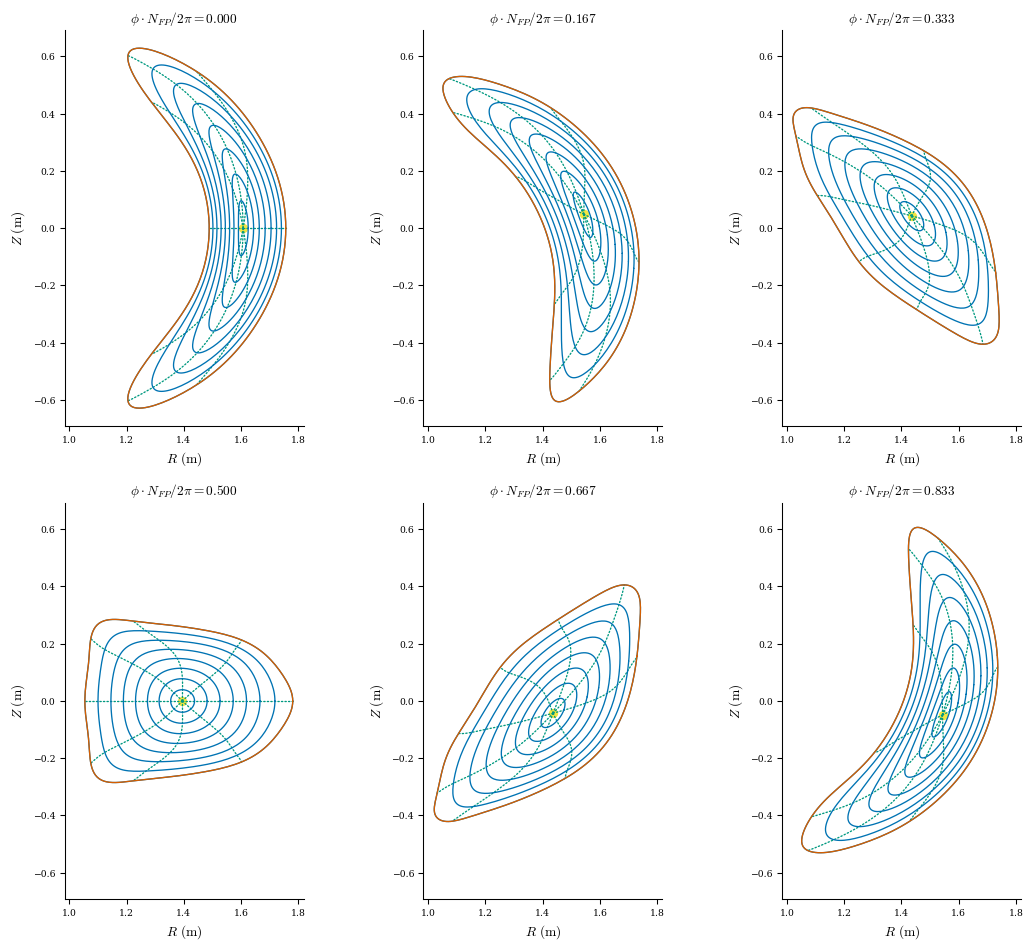

In [5]:
from desc.plotting import plot_surfaces
from desc.equilibrium import Equilibrium

# load the equilibrium and plot the surfaces
# stored data was originally an EquilibriumFamily, so we need to get the last equilibrium
eq = Equilibrium.load(names[0])[-1]  
# names is a list of names (not in this case but it could be), so we need to get 
# the one ending with .h5
plot_surfaces(eq);

This functionality is added primarily for 2 main purposes:

- Make accessing the published simulation results easier by their ID

- Facilitate accesing data automatically for possible machine learning model trainings i.e. create a for loop for a range of ID and import data to train a model.

## Using Stelladb on devices with no Web Browser

Previous two methods assume that the user have installed `Google Chrome`, `Safari`, `Firefox` or `Edge` on their computer. If you don't have any (i.e. some clusters or WSL) or for some other reason you need to upload through website manually, you can follow these steps. First, you need to create `desc_runs.csv`, `configurations.csv`  and optionally plots and device files. You can use `generate_files_desc` function which has the same input arguments. 

This method is especially usefull if you want to create the computationally expensive files on the cluster, and upload the files (which is really fast even on small laptops) from another device.

In [6]:
# create the equilibrium object
eq = get('ATF')

# upload to the equilibrium to database with plots
generate_files_desc(eq, config_name='tutorial_ATF', user='test-user-id', uploadPlots=True)
plt.close()

Zipping files...
Saving equilibrium to .h5 file...
Creating desc_runs.csv and configurations.csv...
Plotting/saving surface, Boozer and 3D plots...
Creating folder tutorial_ATF...
Moving files to the folder...


This function will create a folder named after `config_name`, and put all the generated files there. You can use `upload_files_desc` function with single argument that is the `folder_name` (and optional `verbose` to see which files are uploaded etc.). It will automatically upload the files to the corresponding places in the database.

In [7]:
upload_files_desc('tutorial_ATF', verbose=2)

Uploading contents of tutorial_ATF to database...

Files to upload: ['tutorial_ATF/tutorial_ATF.zip', 'tutorial_ATF/desc_runs.csv', 'tutorial_ATF/configurations.csv', 'tutorial_ATF/tutorial_ATF_surface.webp', 'tutorial_ATF/tutorial_ATF_boozer.webp', 'tutorial_ATF/tutorial_ATF_3d.html']
Configuration data successfully uploaded.
Your data is stored in `configurations` table with name: tutorial_ATF
DESC data successfully uploaded.
Your data is stored in `desc_runs` table with id: 410
The file tutorial_ATF.zip has been uploaded as desc_410_tutorial_ATF.zip
The file tutorial_ATF_surface.webp has been uploaded as surface_desc_410_tutorial_ATF.webp
The file tutorial_ATF_boozer.webp has been uploaded as boozer_desc_410_tutorial_ATF.webp
The file tutorial_ATF_3d.html has been uploaded as plot3d_desc_410_tutorial_ATF.html


This strategy can be easily applied to large amounts of equilibria to create a folder structure, and upload them in a for loop.